In [1]:
cd /home/sam/coreset-nn

/home/sam/coreset-nn


/home/sam/anaconda3/envs/py10-coreset/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from src.sumformer import * 
from src.transformer import *
from src.dataset import *
from src.data_representation import Batch

from torch.optim import Adam

from torch.nn import CrossEntropyLoss, NLLLoss
from torch.utils.data import DataLoader

import argparse
import os
import yaml
import numpy as np
import csv
import logging
from tqdm import tqdm, trange
import geomloss

from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt

In [3]:
def npz_to_batches(raw_data, batch_size=128):

    batch_list = []
    gt_list = []
    in_batch =[]
    in_batch_gt = []
    count = 0

    for i in range(raw_data.shape[0]):
        ptset = raw_data[i][:, :-1]
        cvx_hull_idx = np.where(raw_data[i][:, -1] == 1.0)
        in_batch.append(torch.tensor(ptset, dtype=torch.float))
        in_batch_gt.append(torch.tensor(ptset[cvx_hull_idx], dtype=torch.float))
        if (count != 0 and count % (batch_size-1) == 0) or i == raw_data.shape[0] - 1:
            batch = Batch.from_list(in_batch, order = 1)
            batch_list.append(batch)
            gt_list.append(in_batch_gt)
            in_batch = []
            in_batch_gt = []
        count += 1
    return batch_list, gt_list

In [16]:
train_file = '/data/sam/coreset/data/50_mnet.npy'

raw_data = np.load(train_file)
print(raw_data.shape)

test_batches, test_gt = npz_to_batches(raw_data[1700:], 300)


(2048, 50, 4)


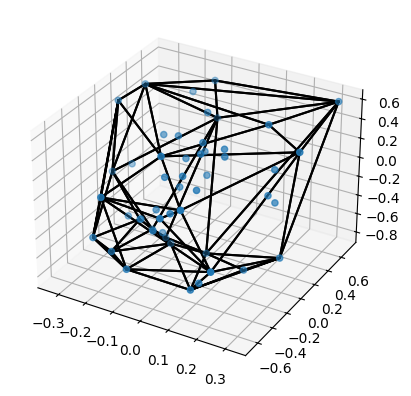

In [19]:
# Visualization of first val
fig = plt.figure()
ax = fig.add_subplot(projection="3d")


points = test_batches[0].data[50:100].numpy()
ax.scatter(points[:, 0], points[:, 1], points[:, 2])

hull = ConvexHull(points)
for simplex in hull.simplices:
    s = np.append(simplex, simplex[0]) 
    plt.plot(points[s, 0], points[s, 1],points[s, 2], 'k-')
# plt.scatter(test_gt[0][0][:, 0], test_gt[0][0][:, 1])
# print(hull.area)

In [20]:
def get_approx_chull(probabilities, batch):
    hulls = []
    start = 0
    for num in batch.n_nodes:
        end = start + num
        ptset = batch.data[start:end]
        ptset_probs = probabilities.data[start:end]
        hull_approx = torch.mm(ptset_probs.T, ptset)
        hulls.append(hull_approx)
        start = end
    return hulls

In [28]:
# load models
approx_hulls = {}

with open('model-configs/change-output-dim-1-in-dim-3.yml', 'r') as file:
    model_configs = yaml.safe_load(file)

for modelname in model_configs:
    config = model_configs[modelname]
    model = ConvexHullNN(**config)
    model_path = f'/data/sam/coreset/models/modelnet-50/ConvexHullNN/sinkhorn/{modelname}/1/final_model.pt'
    if not os.path.exists(model_path):
        continue
    

    state_dict = torch.load(model_path, map_location='cpu')
    
    model.load_state_dict(state_dict)
    model.eval()
    
    out = F.softmax(model(test_batches[0]), dim=1)
    
    hulls = get_approx_chull(out, test_batches[0])
    
    approx_hulls[modelname] = hulls
    
    

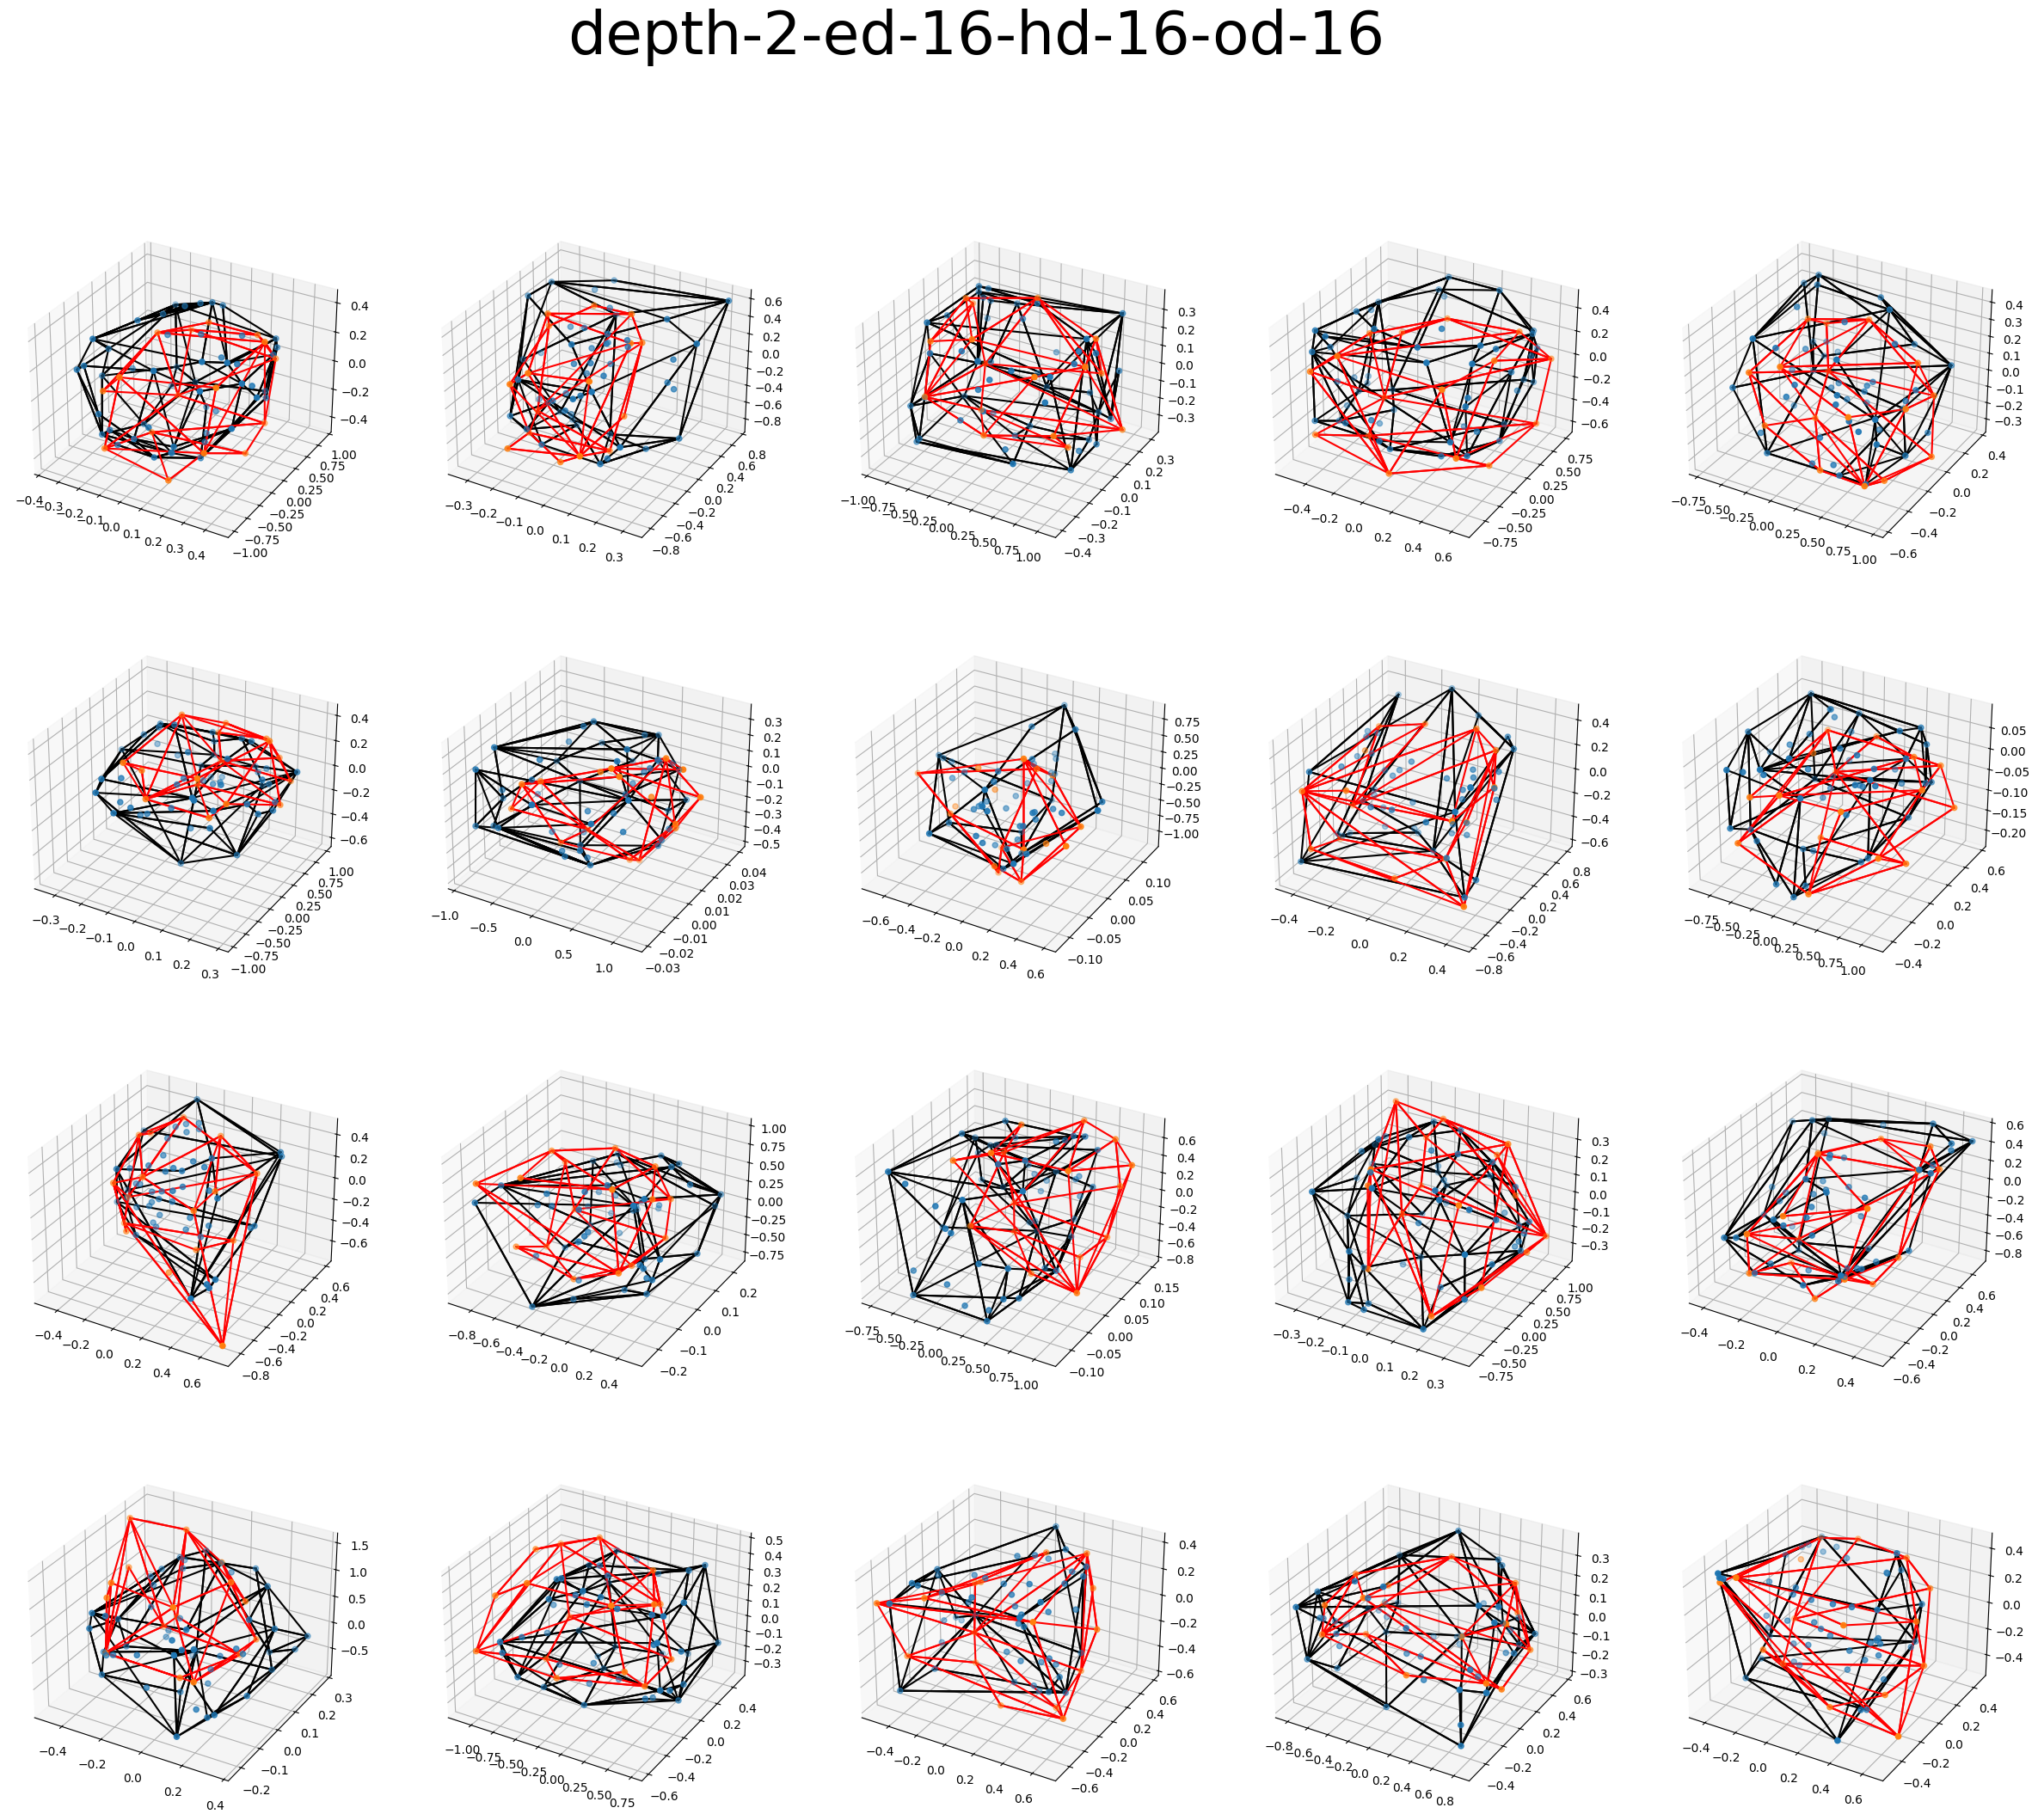

In [30]:

for modelname in approx_hulls:
    fig = plt.figure(figsize=(30, 24))
    for i in range(20):
        ax = fig.add_subplot(4, 5, i + 1, projection='3d')

        points = test_batches[0].data[50*i:50*(i + 1)].numpy()
        ax.scatter(points[:, 0], points[:, 1], points[:, 2])
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            ax.plot(points[simplex, 0], points[simplex, 1], points[simplex,2], 'k-')
        ahull = approx_hulls[modelname][i].detach().numpy()
        ax.scatter(ahull[:, 0], ahull[:, 1], ahull[:, 2])

        a_chull = ConvexHull(ahull)
        for simplex in a_chull.simplices:
            ax.plot(ahull[simplex, 0], ahull[simplex, 1], ahull[simplex,2], color='red')
    fig.suptitle(modelname, fontsize=50)
    fig.savefig(f'images/change-width/{modelname}')
